## Number MNIST generator with GAN

In [1]:
pwd

'/home/uniq/Documents/Deep Learning/VANILLA GAN/notebook'

In [2]:
#import packages
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm

from matplotlib import pyplot as plt


In [3]:
#Hyper parameters
lr = 0.001
batch_size = 64
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Preparations

In [4]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Ensures input range is [-1, 1]
])


In [5]:
mnist_datasets = MNIST('./data',train=True, download=True, transform=image_transforms)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:03<00:00, 3.16MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 101kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:05<00:00, 285kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 18.0kB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
mnist_dataloader = DataLoader(mnist_datasets, batch_size=batch_size, shuffle=True, num_workers = 8, pin_memory=True)

In [7]:
next(iter(mnist_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

# Model Building

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
            

In [9]:
discriminator = Discriminator()
discriminator(torch.rand(10,784)).shape

torch.Size([10, 1])

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # random noise 100 length
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh() #-1 to 1
        )
    def forward(self, x):
        return self.model(x)

In [11]:
generator = Generator()
generator(torch.randn(10,100)).shape

torch.Size([10, 784])

In [12]:
def noise(batch_size,device):
    return torch.randn(batch_size,100).to(device=device)

noise(64, 'cuda').shape

torch.Size([64, 100])

In [13]:

def visualize_samples(generator, device):
    # Generate noise and create fake samples
    samples = generator(noise(16, device)).view(-1, 28, 28).cpu().detach()

    # Create a grid for visualization
    grid = torch.cat([torch.cat([samples[i + j * 4] for i in range(4)], dim=1) for j in range(4)], dim=0)
    
    # Plot the grid
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()


## Model Configurations

In [14]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)
criteria = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001) # gradient is calculated for all the parameters but it is updated only for the discriminator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
ema_generator = Generator().to(device=device)
ema_generator.load_state_dict(generator.state_dict())  # Initialize EMA generator

<All keys matched successfully>

In [15]:
def train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device):
    discriminator.train()
    d_optimizer.zero_grad()
    
    # Smooth labels for real and fake samples
    # Smoothed labels for stability
    real_labels = torch.empty(len(real_image), 1).uniform_(0.8, 1.0).to(device)
    fake_labels = torch.empty(len(fake_image), 1).uniform_(0.0, 0.2).to(device)


    # Forward pass for real images
    real_output = discriminator(real_image)
    real_loss = criteria(real_output, real_labels)

    # Forward pass for fake images
    fake_output = discriminator(fake_image)
    fake_loss = criteria(fake_output, fake_labels)

    # Combine losses
    total_loss = real_loss + fake_loss

    # Backpropagate and update discriminator weights
    total_loss.backward()
    
        # Gradient clipping
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
    
    d_optimizer.step()
    
    return total_loss


In [16]:
torch.zeros(64,1).shape

torch.Size([64, 1])

In [17]:
def train_generator(generator, discriminator, criteria, g_optimizer, fake_image, device):
    g_optimizer.zero_grad()
    
    # Forward pass of discriminator with fake images
    output = discriminator(fake_image)
    
    # Calculate loss for generator to fool the discriminator
    loss = criteria(output, torch.ones(len(output), 1).to(device=device))  # Target is "real" for fake images

    # Backpropagation and optimizer step
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

    g_optimizer.step()
    return loss.item()  # Return scalar loss


In [18]:
def update_ema(ema_generator, generator, alpha=0.999):
    for ema_param, param in zip(ema_generator.parameters(), generator.parameters()):
        ema_param.data = alpha * ema_param.data + (1 - alpha) * param.data

In [19]:
def update_ema(ema_model, model, alpha=0.999):
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data = alpha * ema_param.data + (1 - alpha) * param.data

Train 1 of 100: 100%|██████████| 938/938 [00:15<00:00, 59.69it/s]


Epoch 1/100
Generator Loss: 2136.1811, Discriminator Loss: 775.6838


Train 2 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.41it/s]


Epoch 2/100
Generator Loss: 1724.1221, Discriminator Loss: 954.1490


Train 3 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.48it/s]


Epoch 3/100
Generator Loss: 1782.4133, Discriminator Loss: 852.7482


Train 4 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.40it/s]


Epoch 4/100
Generator Loss: 1799.8733, Discriminator Loss: 870.7028


Train 5 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.41it/s]


Epoch 5/100
Generator Loss: 1622.2921, Discriminator Loss: 911.8436


Train 6 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.25it/s]


Epoch 6/100
Generator Loss: 1566.5029, Discriminator Loss: 919.2992


Train 7 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.56it/s]


Epoch 7/100
Generator Loss: 1419.7853, Discriminator Loss: 974.8071


Train 8 of 100: 100%|██████████| 938/938 [00:16<00:00, 58.15it/s]


Epoch 8/100
Generator Loss: 1327.0953, Discriminator Loss: 1002.8983


Train 9 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.93it/s]


Epoch 9/100
Generator Loss: 1276.9086, Discriminator Loss: 1024.7012


Train 10 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.63it/s]


Epoch 10/100
Generator Loss: 1236.7252, Discriminator Loss: 1034.3708


Train 11 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.05it/s]


Epoch 11/100
Generator Loss: 1219.6897, Discriminator Loss: 1043.0209


Train 12 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.48it/s]


Epoch 12/100
Generator Loss: 1138.3605, Discriminator Loss: 1075.4226


Train 13 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.06it/s]


Epoch 13/100
Generator Loss: 1103.2341, Discriminator Loss: 1087.7919


Train 14 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.35it/s]


Epoch 14/100
Generator Loss: 1106.3424, Discriminator Loss: 1086.8546


Train 15 of 100: 100%|██████████| 938/938 [00:14<00:00, 65.00it/s]


Epoch 15/100
Generator Loss: 1087.3862, Discriminator Loss: 1094.5527


Train 16 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.95it/s]


Epoch 16/100
Generator Loss: 1096.5813, Discriminator Loss: 1085.9388


Train 17 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.11it/s]


Epoch 17/100
Generator Loss: 1050.3022, Discriminator Loss: 1112.2692


Train 18 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.59it/s]


Epoch 18/100
Generator Loss: 1059.2578, Discriminator Loss: 1105.9827


Train 19 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.36it/s]


Epoch 19/100
Generator Loss: 1036.8740, Discriminator Loss: 1117.1414


Train 20 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.27it/s]

Epoch 20/100
Generator Loss: 991.4430, Discriminator Loss: 1132.2883


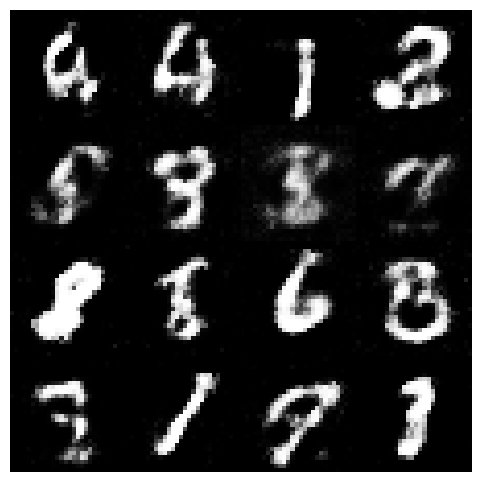

Train 21 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.99it/s]


Epoch 21/100
Generator Loss: 938.5017, Discriminator Loss: 1159.9894


Train 22 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.75it/s]


Epoch 22/100
Generator Loss: 931.6361, Discriminator Loss: 1165.3029


Train 23 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.66it/s]


Epoch 23/100
Generator Loss: 944.5889, Discriminator Loss: 1159.6860


Train 24 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.91it/s]


Epoch 24/100
Generator Loss: 932.1763, Discriminator Loss: 1162.3422


Train 25 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.23it/s]


Epoch 25/100
Generator Loss: 907.2646, Discriminator Loss: 1176.7965


Train 26 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.84it/s]


Epoch 26/100
Generator Loss: 902.0878, Discriminator Loss: 1173.4932


Train 27 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.18it/s]


Epoch 27/100
Generator Loss: 894.6144, Discriminator Loss: 1185.0240


Train 28 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.51it/s]


Epoch 28/100
Generator Loss: 869.1948, Discriminator Loss: 1192.0570


Train 29 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.28it/s]


Epoch 29/100
Generator Loss: 879.6096, Discriminator Loss: 1187.9031


Train 30 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.88it/s]


Epoch 30/100
Generator Loss: 876.3344, Discriminator Loss: 1188.1761


Train 31 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.67it/s]


Epoch 31/100
Generator Loss: 882.9669, Discriminator Loss: 1187.2294


Train 32 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.82it/s]


Epoch 32/100
Generator Loss: 866.9838, Discriminator Loss: 1197.1929


Train 33 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.16it/s]


Epoch 33/100
Generator Loss: 846.5692, Discriminator Loss: 1204.9286


Train 34 of 100: 100%|██████████| 938/938 [00:14<00:00, 64.20it/s]


Epoch 34/100
Generator Loss: 857.8692, Discriminator Loss: 1200.7358


Train 35 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.95it/s]


Epoch 35/100
Generator Loss: 847.9249, Discriminator Loss: 1203.5090


Train 36 of 100: 100%|██████████| 938/938 [00:13<00:00, 70.98it/s]


Epoch 36/100
Generator Loss: 834.6434, Discriminator Loss: 1212.7070


Train 37 of 100: 100%|██████████| 938/938 [00:13<00:00, 71.45it/s]


Epoch 37/100
Generator Loss: 832.2675, Discriminator Loss: 1210.0497


Train 38 of 100: 100%|██████████| 938/938 [00:13<00:00, 70.82it/s]


Epoch 38/100
Generator Loss: 829.9466, Discriminator Loss: 1211.2725


Train 39 of 100: 100%|██████████| 938/938 [00:13<00:00, 70.04it/s]


Epoch 39/100
Generator Loss: 824.4533, Discriminator Loss: 1215.8756


Train 40 of 100: 100%|██████████| 938/938 [00:13<00:00, 70.27it/s]

Epoch 40/100
Generator Loss: 830.7977, Discriminator Loss: 1211.0499


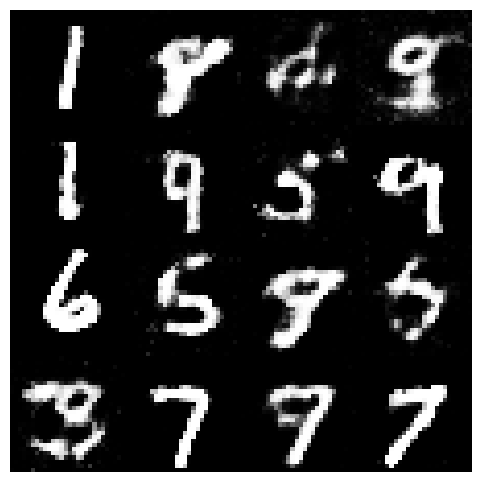

Train 41 of 100: 100%|██████████| 938/938 [00:13<00:00, 70.04it/s]


Epoch 41/100
Generator Loss: 815.5127, Discriminator Loss: 1216.6621


Train 42 of 100: 100%|██████████| 938/938 [00:13<00:00, 69.81it/s]


Epoch 42/100
Generator Loss: 808.1679, Discriminator Loss: 1224.1033


Train 43 of 100: 100%|██████████| 938/938 [00:15<00:00, 58.70it/s]


Epoch 43/100
Generator Loss: 809.4563, Discriminator Loss: 1223.6675


Train 44 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.13it/s]


Epoch 44/100
Generator Loss: 798.6610, Discriminator Loss: 1226.2847


Train 45 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.88it/s]


Epoch 45/100
Generator Loss: 801.6969, Discriminator Loss: 1226.4575


Train 46 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.22it/s]


Epoch 46/100
Generator Loss: 787.6325, Discriminator Loss: 1234.8397


Train 47 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.61it/s]


Epoch 47/100
Generator Loss: 796.0395, Discriminator Loss: 1229.3169


Train 48 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.96it/s]


Epoch 48/100
Generator Loss: 786.9326, Discriminator Loss: 1232.2705


Train 49 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.35it/s]


Epoch 49/100
Generator Loss: 784.3049, Discriminator Loss: 1235.7255


Train 50 of 100: 100%|██████████| 938/938 [00:15<00:00, 58.94it/s]


Epoch 50/100
Generator Loss: 788.5361, Discriminator Loss: 1233.7604


Train 51 of 100: 100%|██████████| 938/938 [00:16<00:00, 56.39it/s]


Epoch 51/100
Generator Loss: 780.4777, Discriminator Loss: 1235.6669


Train 52 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.73it/s]


Epoch 52/100
Generator Loss: 784.5092, Discriminator Loss: 1231.7950


Train 53 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.25it/s]


Epoch 53/100
Generator Loss: 777.9880, Discriminator Loss: 1238.6112


Train 54 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.67it/s]


Epoch 54/100
Generator Loss: 777.0250, Discriminator Loss: 1237.4154


Train 55 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.24it/s]


Epoch 55/100
Generator Loss: 772.3078, Discriminator Loss: 1242.6334


Train 56 of 100: 100%|██████████| 938/938 [00:15<00:00, 59.44it/s]


Epoch 56/100
Generator Loss: 771.8715, Discriminator Loss: 1239.7080


Train 57 of 100: 100%|██████████| 938/938 [00:17<00:00, 54.38it/s]


Epoch 57/100
Generator Loss: 769.4307, Discriminator Loss: 1241.5104


Train 58 of 100: 100%|██████████| 938/938 [00:16<00:00, 55.53it/s]


Epoch 58/100
Generator Loss: 771.5499, Discriminator Loss: 1239.8357


Train 59 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


Epoch 59/100
Generator Loss: 769.3070, Discriminator Loss: 1241.6304


Train 60 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.62it/s]

Epoch 60/100
Generator Loss: 767.3424, Discriminator Loss: 1242.6454


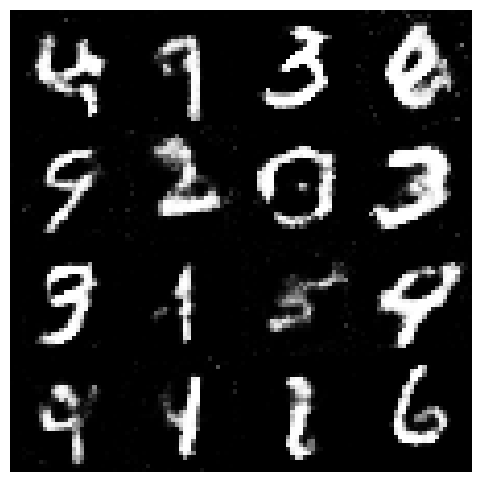

Train 61 of 100: 100%|██████████| 938/938 [00:14<00:00, 62.62it/s]


Epoch 61/100
Generator Loss: 759.0124, Discriminator Loss: 1244.3115


Train 62 of 100: 100%|██████████| 938/938 [00:14<00:00, 63.27it/s]


Epoch 62/100
Generator Loss: 755.7416, Discriminator Loss: 1247.3677


Train 63 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.87it/s]


Epoch 63/100
Generator Loss: 757.5509, Discriminator Loss: 1245.8363


Train 64 of 100: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s]


Epoch 64/100
Generator Loss: 760.0892, Discriminator Loss: 1244.0913


Train 65 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.45it/s]


Epoch 65/100
Generator Loss: 759.5205, Discriminator Loss: 1246.6755


Train 66 of 100: 100%|██████████| 938/938 [00:15<00:00, 62.39it/s]


Epoch 66/100
Generator Loss: 753.2816, Discriminator Loss: 1248.2085


Train 67 of 100: 100%|██████████| 938/938 [00:15<00:00, 61.33it/s]


Epoch 67/100
Generator Loss: 754.6394, Discriminator Loss: 1248.5400


Train 68 of 100: 100%|██████████| 938/938 [00:15<00:00, 59.67it/s]


Epoch 68/100
Generator Loss: 756.3674, Discriminator Loss: 1249.8326


Train 69 of 100: 100%|██████████| 938/938 [00:15<00:00, 60.94it/s]


Epoch 69/100
Generator Loss: 752.1759, Discriminator Loss: 1248.9951


Train 70 of 100: 100%|██████████| 938/938 [00:10<00:00, 86.87it/s] 


Epoch 70/100
Generator Loss: 754.6405, Discriminator Loss: 1248.2650


Train 71 of 100: 100%|██████████| 938/938 [00:10<00:00, 92.27it/s] 


Epoch 71/100
Generator Loss: 758.3512, Discriminator Loss: 1247.2197


Train 72 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.56it/s] 


Epoch 72/100
Generator Loss: 752.2457, Discriminator Loss: 1249.8260


Train 73 of 100: 100%|██████████| 938/938 [00:11<00:00, 82.22it/s]


Epoch 73/100
Generator Loss: 751.6093, Discriminator Loss: 1249.2898


Train 74 of 100: 100%|██████████| 938/938 [00:11<00:00, 81.04it/s] 


Epoch 74/100
Generator Loss: 752.7105, Discriminator Loss: 1245.6201


Train 75 of 100: 100%|██████████| 938/938 [00:11<00:00, 78.73it/s]


Epoch 75/100
Generator Loss: 755.4063, Discriminator Loss: 1246.2635


Train 76 of 100: 100%|██████████| 938/938 [00:11<00:00, 78.72it/s] 


Epoch 76/100
Generator Loss: 753.3582, Discriminator Loss: 1248.9648


Train 77 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.09it/s] 


Epoch 77/100
Generator Loss: 748.2442, Discriminator Loss: 1251.2167


Train 78 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.06it/s] 


Epoch 78/100
Generator Loss: 749.7782, Discriminator Loss: 1254.3258


Train 79 of 100: 100%|██████████| 938/938 [00:11<00:00, 84.75it/s] 


Epoch 79/100
Generator Loss: 750.2333, Discriminator Loss: 1252.2300


Train 80 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.30it/s] 


Epoch 80/100
Generator Loss: 746.7486, Discriminator Loss: 1250.6492


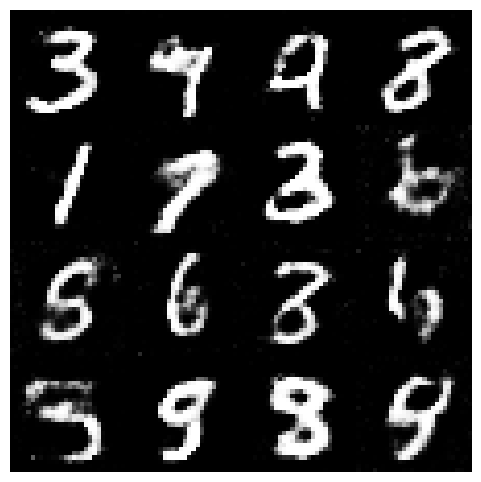

Train 81 of 100: 100%|██████████| 938/938 [00:11<00:00, 82.08it/s] 


Epoch 81/100
Generator Loss: 737.3026, Discriminator Loss: 1253.7424


Train 82 of 100: 100%|██████████| 938/938 [00:10<00:00, 89.04it/s] 


Epoch 82/100
Generator Loss: 739.7536, Discriminator Loss: 1254.4568


Train 83 of 100: 100%|██████████| 938/938 [00:10<00:00, 88.95it/s] 


Epoch 83/100
Generator Loss: 737.7033, Discriminator Loss: 1257.0847


Train 84 of 100: 100%|██████████| 938/938 [00:10<00:00, 90.94it/s] 


Epoch 84/100
Generator Loss: 738.1800, Discriminator Loss: 1252.9519


Train 85 of 100: 100%|██████████| 938/938 [00:10<00:00, 90.11it/s] 


Epoch 85/100
Generator Loss: 742.6524, Discriminator Loss: 1255.8390


Train 86 of 100: 100%|██████████| 938/938 [00:10<00:00, 91.19it/s] 


Epoch 86/100
Generator Loss: 741.8996, Discriminator Loss: 1255.2491


Train 87 of 100: 100%|██████████| 938/938 [00:10<00:00, 89.35it/s] 


Epoch 87/100
Generator Loss: 739.3609, Discriminator Loss: 1255.6482


Train 88 of 100: 100%|██████████| 938/938 [00:10<00:00, 86.56it/s] 


Epoch 88/100
Generator Loss: 740.7493, Discriminator Loss: 1253.8217


Train 89 of 100: 100%|██████████| 938/938 [00:10<00:00, 89.70it/s] 


Epoch 89/100
Generator Loss: 738.6588, Discriminator Loss: 1256.9690


Train 90 of 100: 100%|██████████| 938/938 [00:10<00:00, 88.47it/s] 


Epoch 90/100
Generator Loss: 735.6841, Discriminator Loss: 1256.4905


Train 91 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.21it/s] 


Epoch 91/100
Generator Loss: 739.3652, Discriminator Loss: 1257.5081


Train 92 of 100: 100%|██████████| 938/938 [00:11<00:00, 84.72it/s] 


Epoch 92/100
Generator Loss: 737.7638, Discriminator Loss: 1255.7513


Train 93 of 100: 100%|██████████| 938/938 [00:10<00:00, 87.45it/s] 


Epoch 93/100
Generator Loss: 736.8421, Discriminator Loss: 1256.9708


Train 94 of 100: 100%|██████████| 938/938 [00:11<00:00, 81.70it/s] 


Epoch 94/100
Generator Loss: 737.0228, Discriminator Loss: 1257.8275


Train 95 of 100: 100%|██████████| 938/938 [00:11<00:00, 79.31it/s] 


Epoch 95/100
Generator Loss: 740.5289, Discriminator Loss: 1254.2548


Train 96 of 100: 100%|██████████| 938/938 [00:10<00:00, 86.27it/s] 


Epoch 96/100
Generator Loss: 739.4837, Discriminator Loss: 1255.4025


Train 97 of 100: 100%|██████████| 938/938 [00:11<00:00, 83.15it/s] 


Epoch 97/100
Generator Loss: 739.0469, Discriminator Loss: 1255.0520


Train 98 of 100: 100%|██████████| 938/938 [00:10<00:00, 85.70it/s] 


Epoch 98/100
Generator Loss: 737.0080, Discriminator Loss: 1257.4399


Train 99 of 100: 100%|██████████| 938/938 [00:11<00:00, 84.87it/s] 


Epoch 99/100
Generator Loss: 739.3847, Discriminator Loss: 1256.7289


Train 100 of 100: 100%|██████████| 938/938 [00:11<00:00, 81.10it/s] 

Epoch 100/100
Generator Loss: 734.9055, Discriminator Loss: 1255.8456


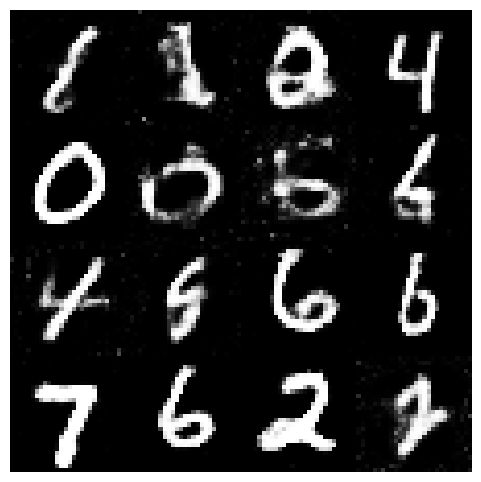

In [20]:
total_gen_loss, total_disc_loss = [], []

# Loop over epochs
for epoch in range(1, num_epochs + 1):
    epoch_gen_loss = 0
    epoch_disc_loss = 0

    # Adjust learning rates every 20 epochs
    if epoch % 20 == 0:
        for param_group in g_optimizer.param_groups:
            param_group['lr'] *= 0.9  # Reduce generator learning rate
        for param_group in d_optimizer.param_groups:
            param_group['lr'] *= 0.9  # Reduce discriminator learning rate

    # Loop over batches
    for images, _ in tqdm(mnist_dataloader, desc=f'Train {epoch} of {num_epochs}'):
        # Prepare real and fake images
        real_image = images.view(len(images), -1).to(device=device)
        fake_image = generator(noise(len(images), device=device))

        # Train the discriminator
        disc_loss = train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device)

        # Generate new fake images
        fake_image = generator(noise(len(images), device=device))

        # Train the generator
        gen_loss = train_generator(generator, discriminator, criteria, g_optimizer, fake_image, device)

        # Update EMA generator
        update_ema(ema_generator, generator)

        # Accumulate losses for the epoch
        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss

    # Print epoch losses
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}")

    # Visualize generated samples
    if epoch % 20 == 0:
        visualize_samples(ema_generator, device)

    # Store losses for later visualization
    total_gen_loss.append(epoch_gen_loss)
    total_disc_loss.append(epoch_disc_loss)


In [21]:
# Save generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

# Optionally, save the EMA generator
torch.save(ema_generator.state_dict(), 'ema_generator.pth')


In [36]:
pwd

'/home/uniq/Documents/Deep Learning/VANILLA GAN/notebook'

In [32]:
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

/tmp/ipykernel_15006/1977227457.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [33]:
z = torch.randn(1, 100).to(device)  # Batch size of 1, noise dim 100


In [34]:
with torch.no_grad():
    generated_image = generator(z).view(-1, 28, 28).cpu()  # Reshape to (1, 28, 28)


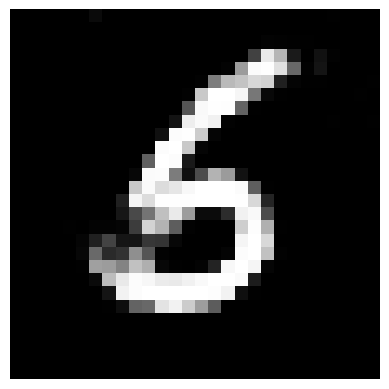

In [35]:
# Visualize the image
plt.imshow(generated_image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()